<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Monire Ameri
### Student ID: 401208091

# Import necessary libraries

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [46]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [47]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

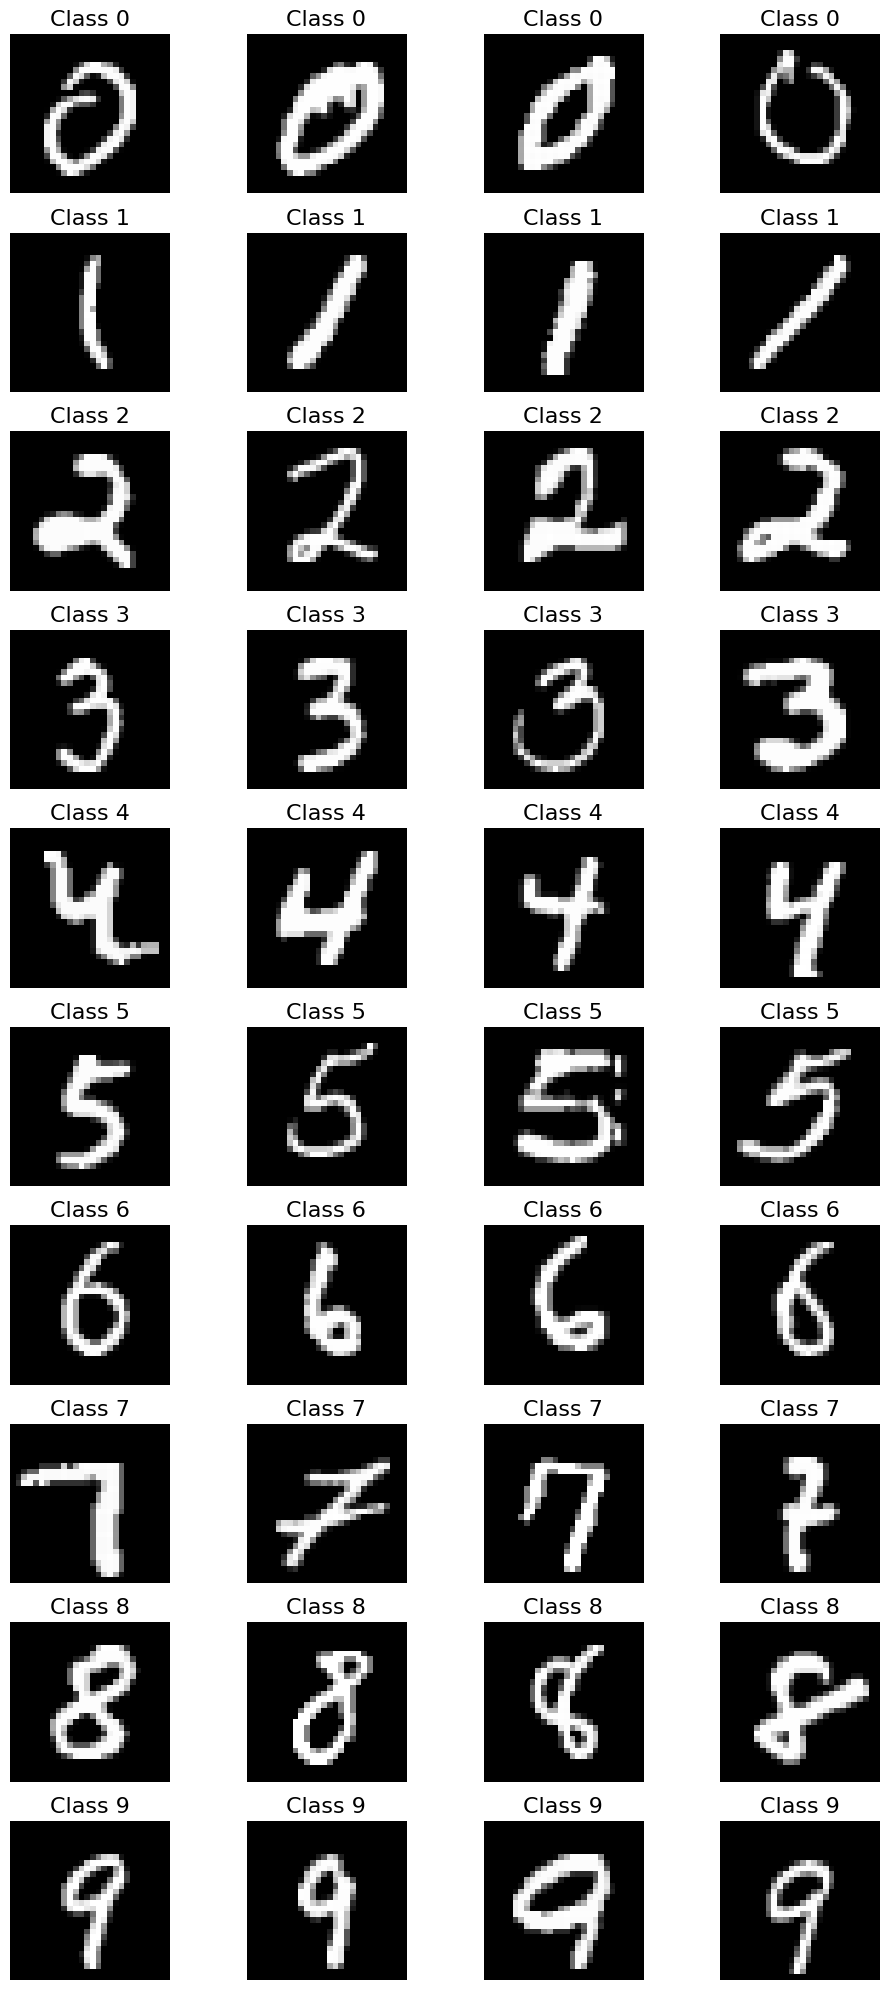

In [48]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [49]:
# Define a simple VAE class with MLP architecture


class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
            
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        
        return recon, mu, logvar

In [50]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [51]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    
    latent_vars = []

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            
            z = model.reparameterize(mu, logvar)
            latent_vars.append(z.detach().numpy())
            
            # TODO: Forward process
            # TODO: Flatten the data and recon tensors
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        np.save('vae_latent_vars.npy', latent_vars)
        
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'E:/M.SC/TERM3/Deep/Hw/Q2 Materials/best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 268.55014969075523
Sample Images:


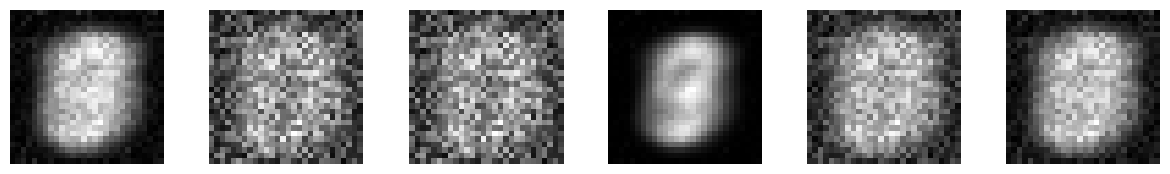


##################################################
VAE-MLP Epoch [2/10], Loss: 203.96211525065104
Sample Images:


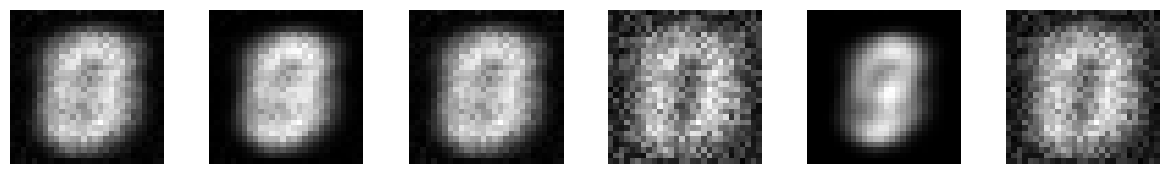


##################################################
VAE-MLP Epoch [3/10], Loss: 199.5329682861328
Sample Images:


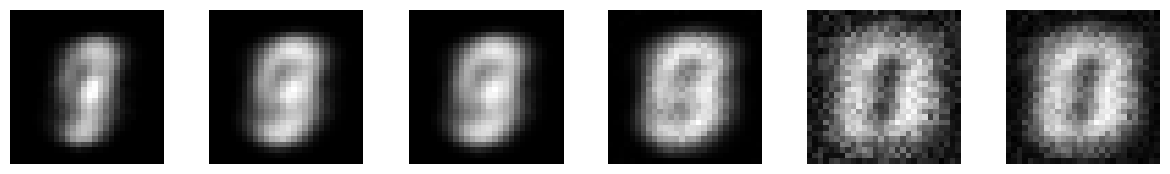


##################################################
VAE-MLP Epoch [4/10], Loss: 196.7285359700521
Sample Images:


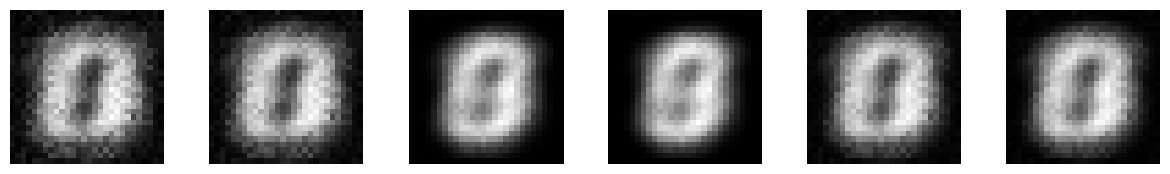


##################################################
VAE-MLP Epoch [5/10], Loss: 194.9077837565104
Sample Images:


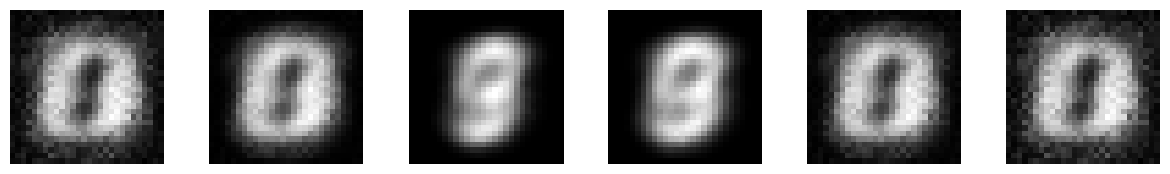


##################################################
VAE-MLP Epoch [6/10], Loss: 193.68043972981772
Sample Images:


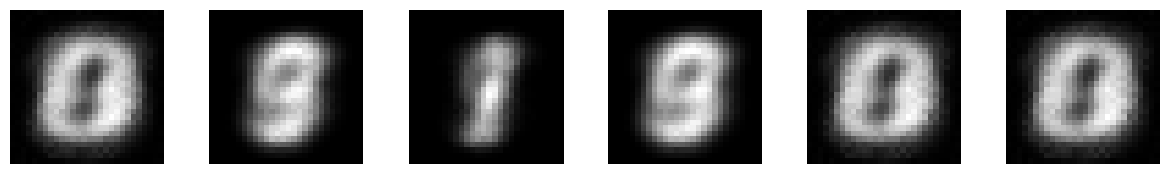


##################################################
VAE-MLP Epoch [7/10], Loss: 192.71316440429686
Sample Images:


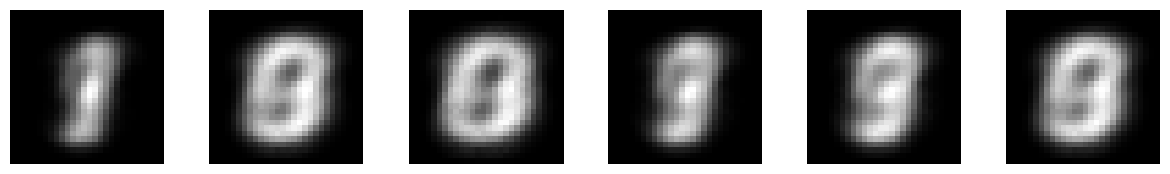


##################################################
VAE-MLP Epoch [8/10], Loss: 191.9465448486328
Sample Images:


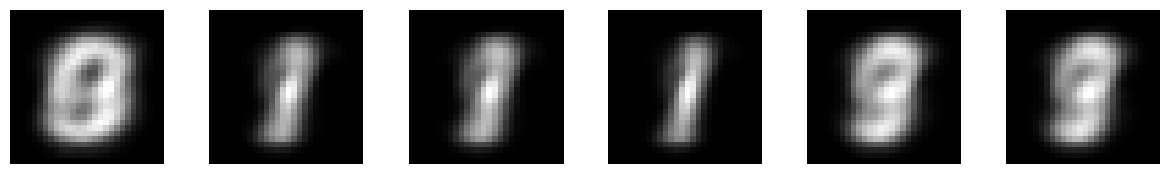


##################################################
VAE-MLP Epoch [9/10], Loss: 191.38289768880207
Sample Images:


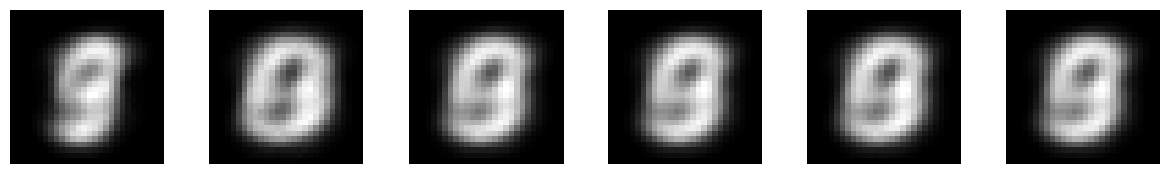


##################################################
VAE-MLP Epoch [10/10], Loss: 190.97438901367187
Sample Images:


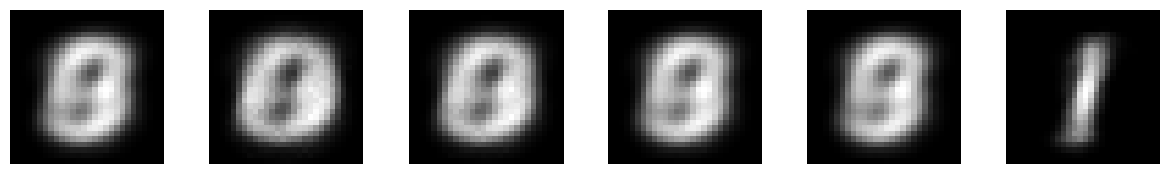

Best model saved as 'best_vae_mlp_model.pth'


In [52]:
# Train VAE-MLP
input_dim = 784
hidden_dim = 3
latent_dim = 2
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [53]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        self.input_size = input_dim
        self.latent_size = latent_dim
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder.
        #i make mistake with x so replace it with X
        X = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(X)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        reconstructed = self.decoder(torch.cat((z, y), dim=1))

        return reconstructed, mu, logvar, class_logits


In [54]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [55]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    
    latent_vars = [] 

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()


            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)
            
            z = model.reparameterize(mu, logvar)
            latent_vars.append(z.detach().numpy())

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        np.save('cvae_latent_vars.npy', latent_vars)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'E:/M.SC/TERM3/Deep/Hw/Q2 Materials/best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 283.0478999267578
Sample Images:


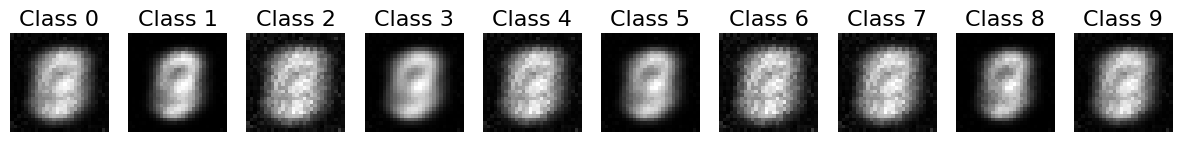


##################################################
CVAE-MLP Epoch [2/10], Loss: 207.7059670654297
Sample Images:


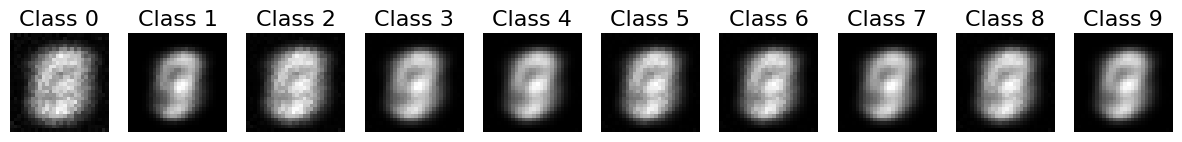


##################################################
CVAE-MLP Epoch [3/10], Loss: 204.26830205078124
Sample Images:


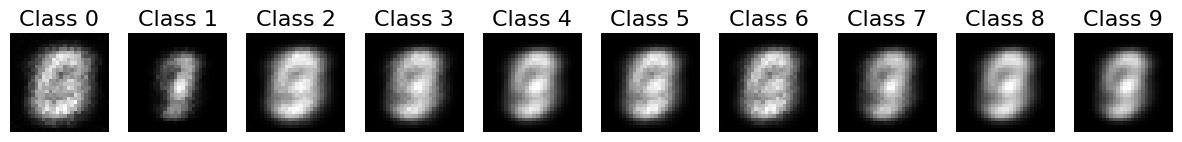


##################################################
CVAE-MLP Epoch [4/10], Loss: 200.96884315592447
Sample Images:


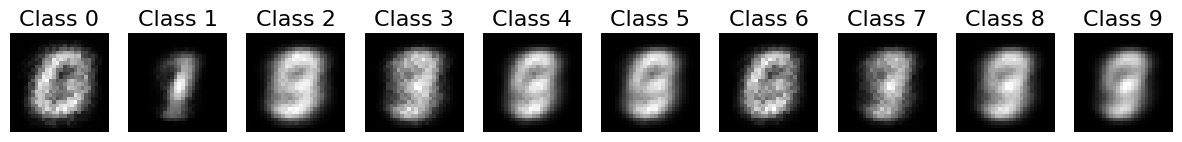


##################################################
CVAE-MLP Epoch [5/10], Loss: 197.97000737304688
Sample Images:


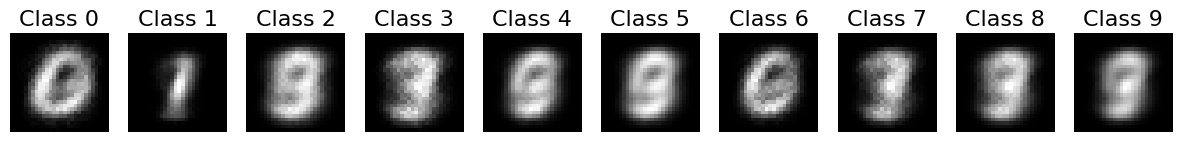


##################################################
CVAE-MLP Epoch [6/10], Loss: 196.1496838216146
Sample Images:


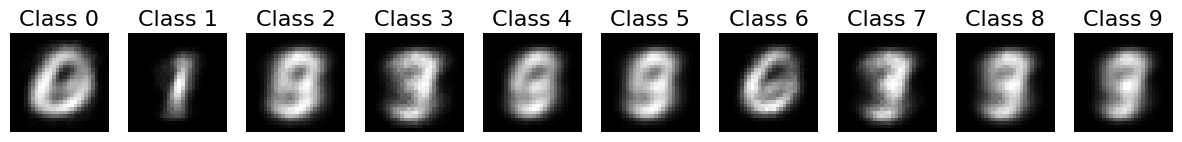


##################################################
CVAE-MLP Epoch [7/10], Loss: 195.0660262451172
Sample Images:


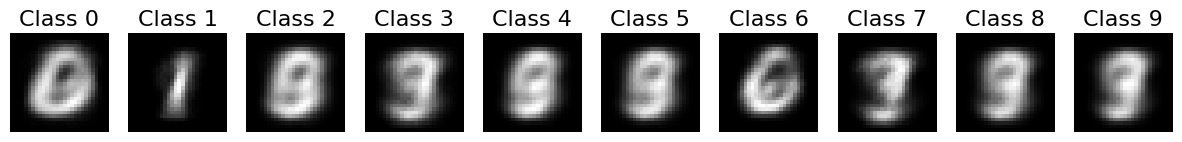


##################################################
CVAE-MLP Epoch [8/10], Loss: 194.09561979166668
Sample Images:


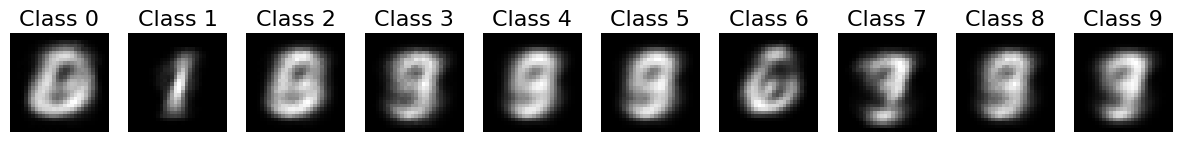


##################################################


In [ ]:
input_dim=784
hidden_dim=3
latent_dim=2
num_classes=10

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


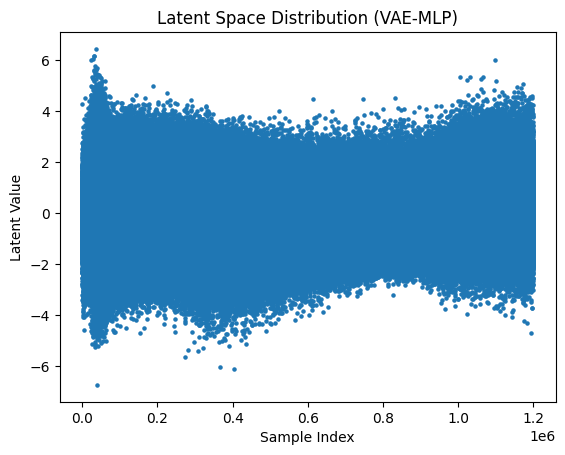

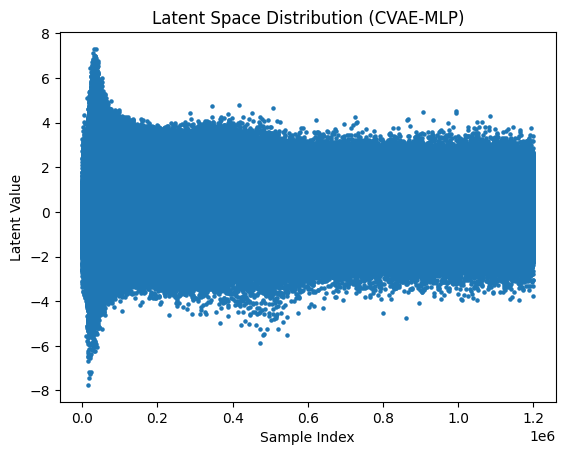

In [44]:
#loading the latent variables for VAE (MLP)
latent_vars_vae = np.load('vae_latent_vars.npy', allow_pickle=True)

#flatten the arrays in latent_vars_vae
latent_vars_vae = np.concatenate(latent_vars_vae).flatten()

#creating x-axis values for VAE (MLP)
x_vae = np.arange(latent_vars_vae.shape[0])

#creating scatter plot of the latent variables for VAE (MLP)
plt.scatter(x_vae, latent_vars_vae, s=5)
plt.xlabel('Sample Index')
plt.ylabel('Latent Value')
plt.title('Latent Space Distribution (VAE-MLP)')
plt.show()

#loading the latent variables for CVAE (MLP)
latent_vars_cvae = np.load('cvae_latent_vars.npy', allow_pickle=True)
latent_vars_cvae = np.concatenate(latent_vars_cvae).flatten()

#creating x-axis values for CVAE (MLP)
x_cvae = np.arange(latent_vars_cvae.shape[0])

#creating scatter plot of the latent variables for CVAE (MLP)
plt.scatter(x_cvae, latent_vars_cvae, s=5)
plt.xlabel('Sample Index')
plt.ylabel('Latent Value')
plt.title('Latent Space Distribution (CVAE-MLP)')
plt.show()